# Imports and global options

In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


from IPython.display import Image

pd.set_option('display.width', 200)

# Load Data

In [2]:
# Load data
df_climate = pd.read_excel('../data/Kalam Climate Data.xlsx')
df_energy = pd.read_csv('../data/Data.csv')

---
---
# EDA

## Climate data

### Check basics:

In [3]:
print(df_climate.info())
df_climate.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12228 entries, 0 to 12227
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date Time                  12228 non-null  datetime64[ns]
 1   Temperature (°C)           12228 non-null  float64       
 2   Dewpoint Temperature (°C)  12228 non-null  float64       
 3   U Wind Component (m/s)     12228 non-null  float64       
 4   V Wind Component (m/s)     12228 non-null  float64       
 5   Total Precipitation (mm)   12228 non-null  float64       
 6   Snowfall (mm)              12228 non-null  float64       
 7   Snow Cover (%)             12228 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 764.4 KB
None


Date Time                    12228
Temperature (°C)             12211
Dewpoint Temperature (°C)    12210
U Wind Component (m/s)       10677
V Wind Component (m/s)       11978
Total Precipitation (mm)      5513
Snowfall (mm)                 2536
Snow Cover (%)                1581
dtype: int64

*No nan values. No double datetime values.*

In [4]:
df_climate.describe()

Date Time  Temperature (°C)  Dewpoint Temperature (°C)  U Wind Component (m/s)  V Wind Component (m/s)  Total Precipitation (mm)  Snowfall (mm)  Snow Cover (%)
count                          12228      12228.000000               12228.000000            12228.000000            12228.000000              12228.000000   12228.000000    12228.000000
mean   2024-02-13 06:30:00.000000256          2.613729                  -3.277329                0.004090               -0.331290                  0.002132       0.001013       52.396897
min              2023-06-03 13:00:00        -22.286047                 -33.665594               -1.084534               -1.461945                  0.000000       0.000000        0.000000
25%              2023-10-08 21:45:00         -6.249209                 -11.992175               -0.085398               -0.848168                  0.000002       0.000000        0.000000
50%              2024-02-13 06:30:00          4.273965                  -1.358336                0.016932               -0.497864                  0.000267       0.000000       60.708984
75%              2024-06-19 15:15:00         11.368826                   6.559595                0.097305                0.105911                  0.002039       0.000004       99.972656
max              2024-10-25 00:00:00         22.351938                  17.047083                1.187332                1.483383                  0.062579       0.062501       99.972656
std                              NaN         10.330212                  11.344587                0.222572                0.666045                  0.005109       0.004730       47.690779

*Looks like we have sound meteorological data.*

### Check time steps:

In [5]:
print(df_climate['Date Time'].sort_values().head(10))
print(df_climate['Date Time'].sort_values().tail(10))
days = (df_climate['Date Time'].sort_values().values[-1]-df_climate['Date Time'].sort_values().values[0]).astype('timedelta64[D]')
print(days)

0   2023-06-03 13:00:00
1   2023-06-03 14:00:00
2   2023-06-03 15:00:00
3   2023-06-03 16:00:00
4   2023-06-03 17:00:00
5   2023-06-03 18:00:00
6   2023-06-03 19:00:00
7   2023-06-03 20:00:00
8   2023-06-03 21:00:00
9   2023-06-03 22:00:00
Name: Date Time, dtype: datetime64[ns]
12218   2024-10-24 15:00:00
12219   2024-10-24 16:00:00
12220   2024-10-24 17:00:00
12221   2024-10-24 18:00:00
12222   2024-10-24 19:00:00
12223   2024-10-24 20:00:00
12224   2024-10-24 21:00:00
12225   2024-10-24 22:00:00
12226   2024-10-24 23:00:00
12227   2024-10-25 00:00:00
Name: Date Time, dtype: datetime64[ns]
509 days


In [6]:
df_climate['Date Time'].count() - days/np.timedelta64(1, 'h')

12.0

*We have consecutive hourly climate data for 509 days and 12 hours, no gaps.*

### Check correlations:

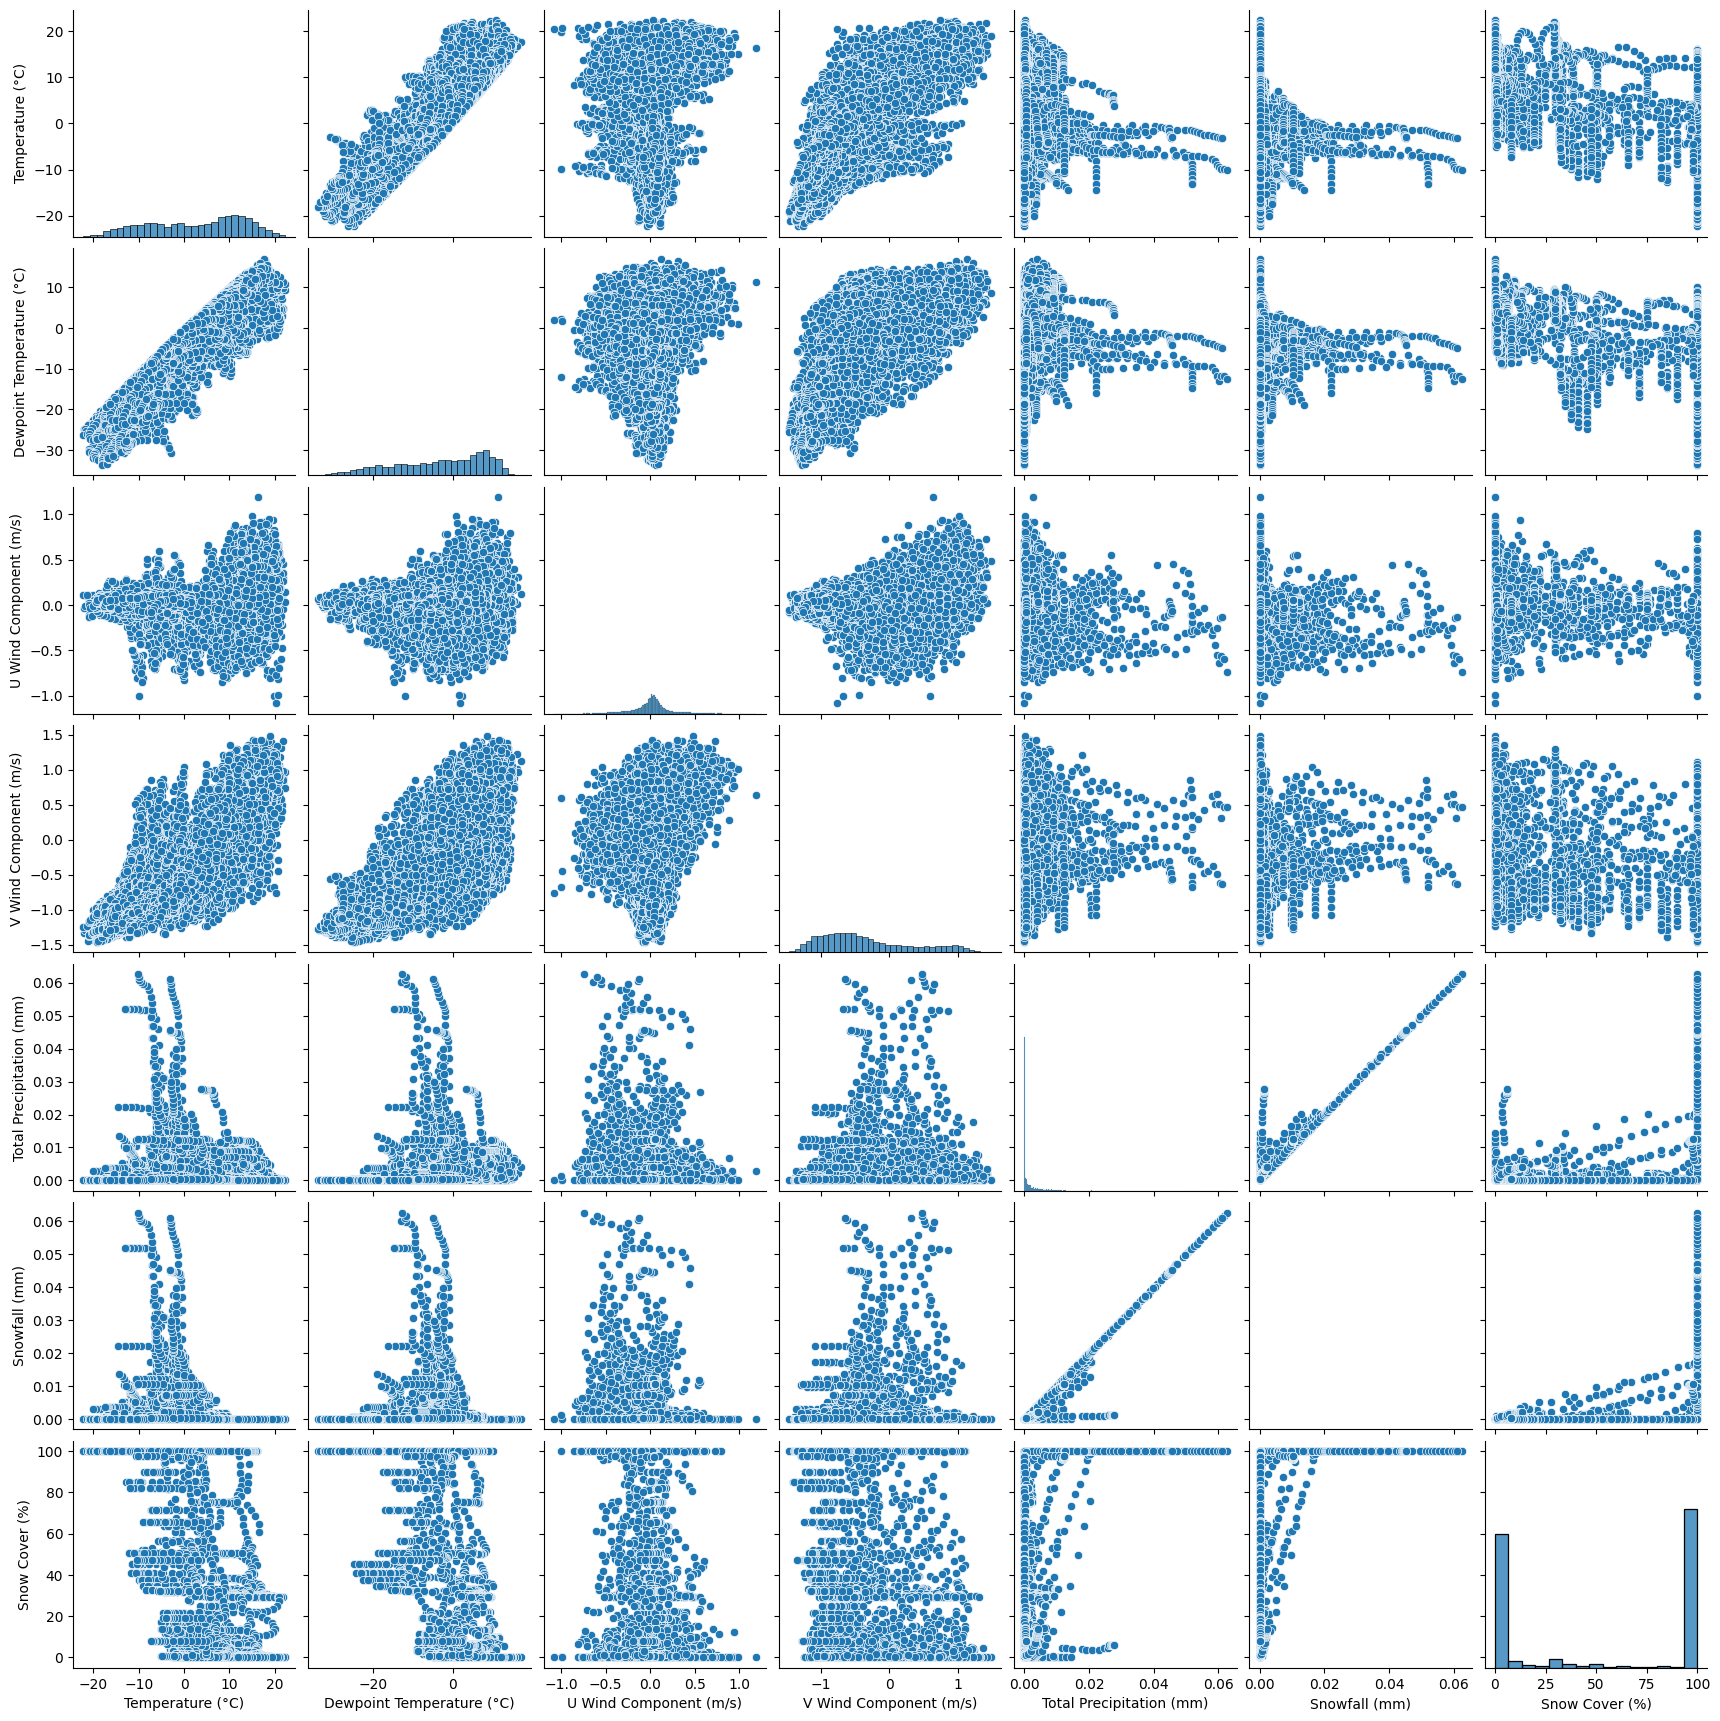

In [7]:
#sns.pairplot(df_climate)
Image(filename='../images/climate_var_correlations.png')

*Some strong correlations between:*
- *temperature & dew point temperature*
- *total precipitation & snowfall*

*Strong bimodal snow cover.*

---
## Energy Data

### Check basics:

In [8]:
print(df_energy.info(show_counts=True))
df_energy.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39147559 entries, 0 to 39147558
Data columns (total 10 columns):
 #   Column             Non-Null Count     Dtype  
---  ------             --------------     -----  
 0   date_time          39147559 non-null  object 
 1   v_red              13819267 non-null  float64
 2   current            39147559 non-null  float64
 3   power_factor       39147559 non-null  float64
 4   kwh                39147559 non-null  float64
 5   Source             39147559 non-null  object 
 6   v_blue             12248394 non-null  float64
 7   v_yellow           13079898 non-null  float64
 8   consumer_device_9  39147559 non-null  int64  
 9   consumer_device_x  39147559 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 2.9+ GB
None


date_time             137803
v_red                  18816
current                 4175
power_factor              97
kwh                  2132866
Source                   585
v_blue                 19048
v_yellow               18970
consumer_device_9          2
consumer_device_x         39
dtype: int64

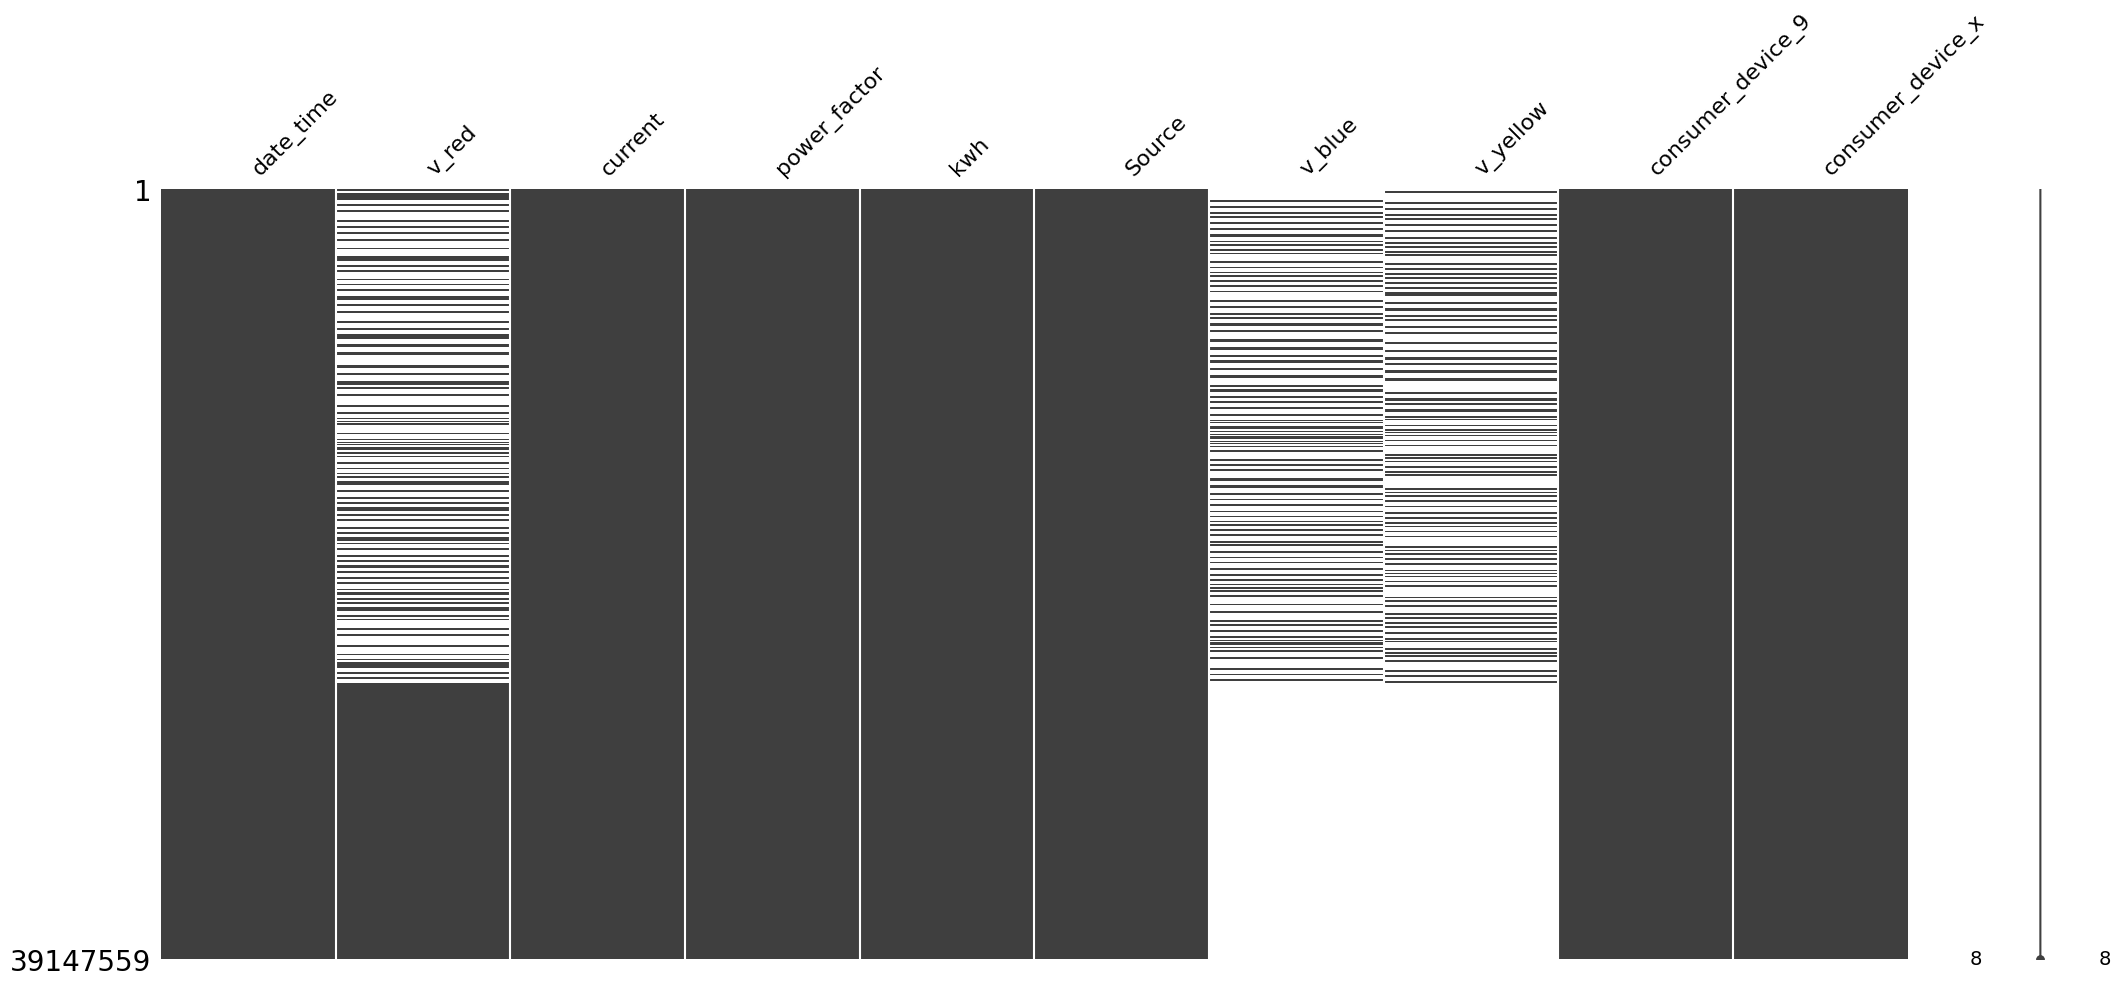

In [9]:
#msno.matrix(df_energy)
Image(filename='../images/missingno_matrix.png')

*There are only one phase households. Most households use the red phase. All three phases add up to the total number of dataframe rows, i. e. there are no missing values outside of the bijective phase selection.*

### Check different power phases:

In [10]:
print('\nRed:')
print(df_energy.loc[df_energy['v_red'] > 0.].loc[df_energy['current'] > 0.].describe())
print('\nBlue:')
print(df_energy.loc[df_energy['v_blue'] > 0.].loc[df_energy['current'] > 0.].describe())
print('\nYellow:')
print(df_energy.loc[df_energy['v_yellow'] > 0.].loc[df_energy['current'] > 0.].describe())


Red:
              v_red       current  power_factor           kwh  v_blue  v_yellow  consumer_device_9  consumer_device_x
count  1.491956e+06  1.491956e+06  1.491956e+06  1.491956e+06     0.0       0.0       1.491956e+06       1.491956e+06
mean   1.658458e+02  2.035727e+00  6.513809e-01  2.198902e-02     NaN       NaN       7.080638e-03       2.056444e+01
std    4.367186e+01  5.053585e+00  2.170422e-01  5.864871e-02     NaN       NaN       8.384812e-02       1.063168e+01
min    5.003000e+01  1.000000e-02  4.000000e-02  8.896250e-06     NaN       NaN       0.000000e+00       1.000000e+00
25%    1.377800e+02  7.000000e-02  6.400000e-01  5.696190e-04     NaN       NaN       0.000000e+00       1.200000e+01
50%    1.782800e+02  1.100000e-01  7.400000e-01  8.888629e-04     NaN       NaN       0.000000e+00       2.100000e+01
75%    1.980300e+02  1.250000e+00  7.600000e-01  1.253962e-02     NaN       NaN       0.000000e+00       2.900000e+01
max    2.400000e+02  4.539000e+01  9.900000e-01  7

*No extreme differences catching the eye. Slightly higher consumption of red phase users.*

### Check ***Source*** and comsumer devices:

In [11]:
print(df_energy.consumer_device_9.unique())
print(df_energy.consumer_device_x.unique())
df_energy.loc[df_energy['consumer_device_9']==1].Source.unique()

[0 1]
[10 11 12 13 14 15 16 17 18 19  1 20 21 22 23 24 25 26 27 28 29  2 30 31
 32 33 34 35 36 37 38 39  3  4  5  6  7  8  9]


array(['consumer_device_9_data_user_1', 'consumer_device_9_data_user_2',
       'consumer_device_9_data_user_3', 'consumer_device_9_data_user_4',
       'consumer_device_9_data_user_5', 'consumer_device_9_data_user_6',
       'consumer_device_9_data_user_7', 'consumer_device_9_data_user_8',
       'consumer_device_9_data_user_9'], dtype=object)

*Consumer_device_9 is completely covered by consumer_device_x. Consumer_device_x is completely covered by Source.*

### Check time steps:

Note: we convert the time data to datetime for better coding accessibility.

In [12]:
# Convert to datetime
df_energy['date_time'] = pd.to_datetime(df_energy['date_time'])

print(df_energy['date_time'].sort_values().head(10))
print(df_energy['date_time'].sort_values().tail(10))
days_e = (df_energy['date_time'].sort_values().values[-1]-df_energy['date_time'].sort_values().values[0]).astype('timedelta64[D]')
print(days_e)

33296362   2023-06-03 12:25:00
33410436   2023-06-03 12:25:00
33980806   2023-06-03 12:25:00
33752658   2023-06-03 12:25:00
33068214   2023-06-03 12:25:00
32954140   2023-06-03 12:25:00
33866732   2023-06-03 12:25:00
32840066   2023-06-03 12:25:00
33638584   2023-06-03 12:25:00
33182288   2023-06-03 12:25:00
Name: date_time, dtype: datetime64[ns]
18684478   2024-09-23 23:55:00
18595970   2024-09-23 23:55:00
9612541    2024-09-23 23:55:00
18507462   2024-09-23 23:55:00
2801630    2024-09-23 23:55:00
18418954   2024-09-23 23:55:00
18330446   2024-09-23 23:55:00
9744160    2024-09-23 23:55:00
18241938   2024-09-23 23:55:00
2889617    2024-09-23 23:55:00
Name: date_time, dtype: datetime64[ns]
478 days


In [13]:
print((df_energy['date_time'].nunique() - days_e/np.timedelta64(5, 'm')) // 12)
(df_energy['date_time'].nunique() - days_e/np.timedelta64(5, 'm')) % 12 * 5

11.0


35.0

*Looks like we have consecutive 5 minute energy data for 478 days, 11 hours and 35 minutes, no gaps. However, data of individual users may exhibit gaps.

This means we have roughly one additional month of climate date, that can be used to predict the energy consumption.*

In [14]:
print(df_energy.Source.unique()[0], '\n')
print(df_energy.loc[df_energy.Source == df_energy.Source.unique()[0]]['date_time'].sort_values().head())
df_energy.loc[df_energy.Source == df_energy.Source.unique()[0]]['date_time'].sort_values().tail()

consumer_device_10_data_user_1 

0   2024-07-22 18:20:00
1   2024-07-22 18:25:00
2   2024-07-22 18:30:00
3   2024-07-22 18:35:00
4   2024-07-22 18:40:00
Name: date_time, dtype: datetime64[ns]


18207   2024-09-23 23:35:00
18208   2024-09-23 23:40:00
18209   2024-09-23 23:45:00
18210   2024-09-23 23:50:00
18211   2024-09-23 23:55:00
Name: date_time, dtype: datetime64[ns]

*A quick look at the first user only already reveals: time data of individual users exhibits gaps, i. e. we may need to fill the gaps with nan values.*

### Check power factor:

In [15]:
#print(df_energy.Source.unique()[0], '\n')
#df_source1 = df_energy.loc[df_energy.Source == df_energy.Source.unique()[0], 'v_red':'kwh'].loc[df_energy['current'] > 0.]
#sns.pairplot(df_source1, diag_kind='kde')
Image(filename='../images/pairplot_consumer1.png')

*No strong correlation observed regarding power factor. There may be a very weak one with current and energy consumption.*

### Check correlations:

In [16]:
df_energy_corr = df_energy.copy()
df_energy_corr.eval('device_user = Source', inplace=True)
df_energy_corr.device_user = df_energy_corr.device_user.apply(lambda x: x[-2:].lstrip('_')).astype(int)
df_energy_corr.eval('device_user = consumer_device_x*100 + device_user', inplace=True)
df_energy_corr.eval('user = Source', inplace=True)
df_energy_corr.user = df_energy_corr.user.apply(lambda x: x[-2:].lstrip('_')).astype(int)
print(df_energy_corr.device_user.unique())
print(df_energy_corr.consumer_device_x.unique())
print(df_energy_corr.user.unique())

[1001 1010 1011 1012 1013 1014 1015 1016 1017 1018 1002 1003 1004 1005
 1006 1007 1008 1009 1101 1110 1111 1112 1113 1114 1115 1116 1117 1118
 1102 1103 1104 1105 1106 1107 1108 1109 1201 1210 1211 1212 1213 1214
 1215 1202 1203 1204 1205 1206 1207 1208 1209 1301 1310 1311 1312 1313
 1314 1315 1316 1317 1318 1302 1303 1304 1305 1306 1307 1308 1309 1401
 1402 1403 1404 1501 1510 1511 1512 1513 1514 1515 1516 1517 1518 1502
 1503 1504 1505 1506 1507 1508 1509 1601 1610 1611 1612 1613 1614 1615
 1616 1617 1618 1602 1603 1604 1605 1606 1607 1608 1609 1701 1710 1711
 1712 1713 1714 1715 1716 1717 1702 1703 1704 1705 1706 1707 1708 1709
 1801 1810 1811 1812 1813 1814 1815 1816 1817 1818 1802 1803 1804 1805
 1806 1807 1808 1809 1901 1910 1911 1912 1913 1914 1915 1916 1917 1902
 1903 1904 1905 1906 1907 1908 1909  101  102  103  104  105  106  107
  108  109 2001 2010 2011 2012 2013 2014 2015 2016 2002 2003 2004 2005
 2006 2007 2008 2009 2101 2110 2111 2112 2113 2114 2115 2116 2117 2118
 2102 

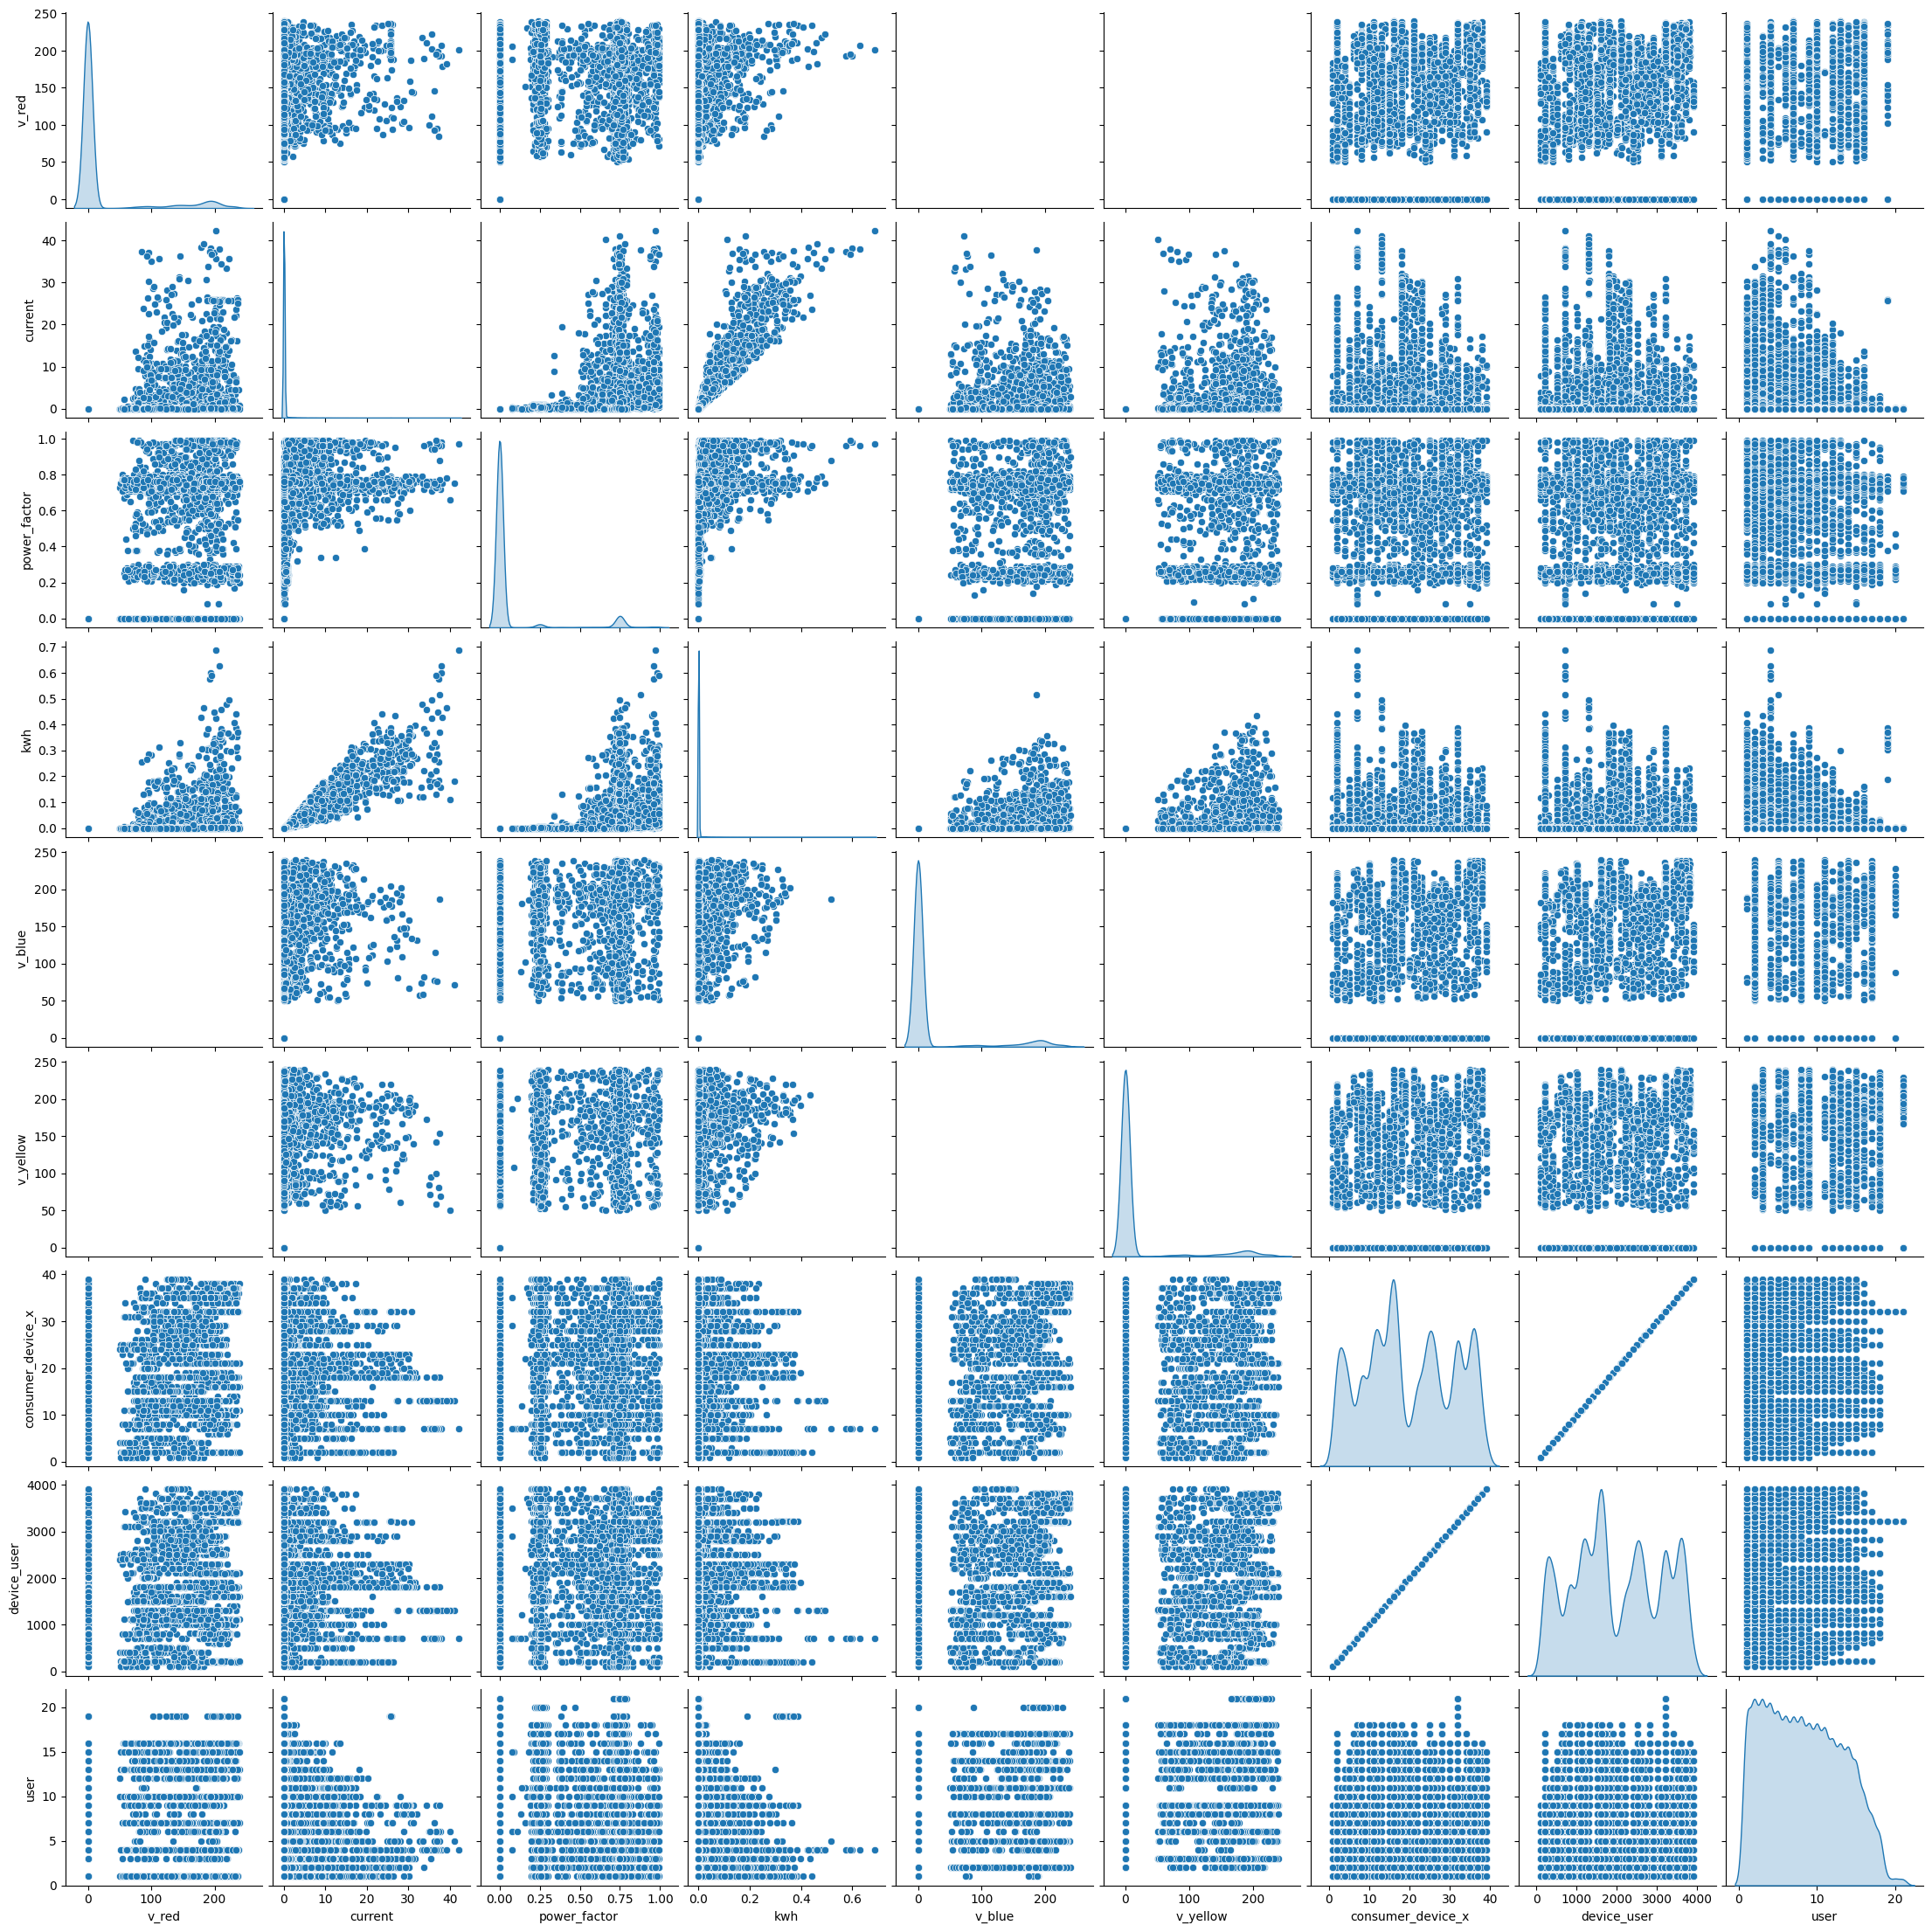

In [17]:
#df_energy_corr.drop(columns=["date_time", "consumer_device_9", "Source"], inplace=True)
#sns.pairplot(df_energy_corr.sample(100000, axis=0), diag_kind='kde')
Image(filename='../images/energy_var_corr.png')

*Strong correlations between:*
- *current & kwh*

*Very weak correlations between:*
- *power factor & kwh*
- *power factor & current*
- *power factor & kwh*
- *kwh & valtages*
- *user & kwh*
- *user & current*

*Correlation between device_user and user is a mathamatical construct.*

### Compare ***kwh*** with mathematical calculation `consumption[Wh] = V * I * Power_Factor * 1h / (1h/dt)`

Note: We divide by 1000 to account for the "kilo" in kWh and multiply by 1h to get the energy, which would be consumed if the user were to consume power for 1 hour. To convert to the given time step resolution we divide by (1h/dt), wich is 12 for dt=5min.

In [18]:
df_energy_math = df_energy.fillna(value=0.).copy()
df_energy_math.eval('diff_consume = kwh - (v_red + v_blue + v_yellow) * current * power_factor / 1000 / 12', inplace=True)
print(df_energy_math.diff_consume.unique())
print('\nAny difference larger than 1e-15:', any((abs(df_energy_math.diff_consume.unique()) > 1e-15) == True))

[ 0.00000000e+00 -9.99634403e-17 -6.66784336e-17 -6.67868538e-17
 -9.98550201e-17  1.08420217e-19 -3.32850067e-17 -9.99092302e-17
 -2.16840434e-19 -3.33934269e-17 -1.08420217e-19 -1.00071861e-16
 -3.35018471e-17 -3.33392168e-17 -2.71050543e-20 -5.42101086e-20
  5.42101086e-20 -1.00017650e-16 -9.99905454e-17 -6.67326437e-17
 -6.66648811e-17 -6.64615932e-17 -6.65700134e-17 -3.33121117e-17
 -1.62630326e-19 -6.66513286e-17 -6.66242235e-17 -3.34476370e-17
 -6.70036943e-17 -9.97465999e-17 -3.36102673e-17 -3.31765865e-17
 -6.68952740e-17 -4.16333634e-17 -9.71445147e-17 -8.32667268e-17
 -1.04083409e-16  6.93889390e-18 -3.38813179e-21 -6.66919861e-17
 -1.35525272e-20 -3.33663219e-17 -6.67055387e-17 -1.38777878e-17
 -2.77555756e-17 -1.11022302e-16  6.77626358e-21 -3.33527693e-17
 -5.55111512e-17 -6.24500451e-17  2.16840434e-19 -1.00613962e-16
 -3.32307966e-17 -1.00180281e-16 -3.30681663e-17 -4.33680869e-19
  1.38777878e-17 -6.93889390e-17 -9.02056208e-17 -6.93889390e-18
 -3.46944695e-17 -7.63278

*We find no significant deviation from the mathematical formular.*

*We conclude the following column information.*

| column name | description | observations |
|---|---|---|
||||
| v_red | Average voltage U (V) of red phase per user and 5 min time step | user exclusive |
| v_blue | Average voltage U (V) of blue phase per user and 5 min time step | user exclusive |
| v_yellow | Average voltage U (V) of yellow phase per user and 5 min time step | user exclusive |
| current | Current I (A) per user and 5 min time step | highly correlated with energy consumption |
| power_factor | Energy efficiency (#) | no significant correlations found |
| kwh | Energy consumption (kWh) per user and 5 min time step | highly correlated with I, following formular: ***V * I * Power Factor * 1/12h*** |
| Source | String combining power pole and connection number of user | String unambiguously identifying user |
| consumer_device_x | Power pole of user | Information included in Source |

---
## Data preparation

Note: The Zindi challenge uses daily aggregated data to evaluate model performance. Therefore we are aggregating all data (climate and energy) to 1 day resolution.

### Climate data

#### Aggregate daily:

In [19]:
# Extract date
df_climate['date'] = df_climate['Date Time'].dt.date

# Daily aggregation
daily_climate = df_climate.groupby('date').agg({
    'Temperature (°C)': ['mean', 'min', 'max'],
    'Dewpoint Temperature (°C)': ['mean', 'min', 'max'],
    'U Wind Component (m/s)': 'mean',
    'V Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum',
    'Snowfall (mm)': 'sum',
    'Snow Cover (%)': 'mean'
})

# Flatten columns
daily_climate.columns = ['_'.join(col).strip() for col in daily_climate.columns.values]

# Reset index
daily_climate = daily_climate.reset_index()

# Define start and end dates for additional month of climate data
start_date = pd.to_datetime('2024-09-24')
end_date   = pd.to_datetime('2024-10-24')

# Ensure datetime
daily_climate["date"] = pd.to_datetime(daily_climate["date"])

# Filter DataFrame
extra_month = daily_climate[(daily_climate['date'] >= start_date) & (daily_climate['date'] <= end_date)]

# Dictionary for new names
new_names = {
    'date': 'Date',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}

# Safe extra month
extra_month.rename(columns=new_names, inplace=True)

/var/folders/xv/2jhhwq6s0yx_pd196qcw40980000gn/T/ipykernel_99236/1360080748.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_month.rename(columns=new_names, inplace=True)


#### Check dataframe:

In [20]:
print(daily_climate.head())
print(extra_month.head())

        date  Temperature (°C)_mean  Temperature (°C)_min  Temperature (°C)_max  Dewpoint Temperature (°C)_mean  Dewpoint Temperature (°C)_min  Dewpoint Temperature (°C)_max  \
0 2023-06-03               1.860280             -1.513861              7.199731                       -3.348664                      -4.697501                      -2.448126   
1 2023-06-04               3.992740             -3.258566              9.100580                       -1.905203                      -5.135535                       0.460703   
2 2023-06-05               4.794523             -4.962714             10.031442                       -3.781657                      -6.197546                      -1.211890   
3 2023-06-06               6.304390              0.213861             11.149500                       -4.670615                      -6.253607                      -1.456351   
4 2023-06-07               7.003922              1.434000             12.092218                       -3.965763    

### Energy data:

#### Streamline and aggregate daily:

In [21]:
# drop redundant columns
df_energy.drop(columns=["consumer_device_9", "consumer_device_x", "v_red", "v_blue","v_yellow","current", "power_factor"], inplace=True)

# Ensure datetime
df_energy['date_time'] = pd.to_datetime(df_energy['date_time'])

# Extract date (drop time)
df_energy['date'] = df_energy['date_time'].dt.date

# Group by Source (consumer_device + data_user) and date
daily_energy = df_energy.groupby(['Source', 'date']).agg({
    'kwh': 'sum'
})

#### Check dataframe:

In [22]:
print(daily_energy.head())

                                                kwh
Source                         date                
consumer_device_10_data_user_1 2024-07-22  0.024330
                               2024-07-23  0.103560
                               2024-07-24  0.137543
                               2024-07-25  0.121011
                               2024-07-26  0.000000


### Merge data:

In [23]:
# Reset index
daily_energy = daily_energy.reset_index()

# Ensure datetime index
daily_energy = daily_energy.set_index("date").sort_index()
daily_climate = daily_climate.set_index("date").sort_index()

# Merge
merged_daily= daily_energy.join(daily_climate, how="left")

# Reset index
merged_daily.reset_index(inplace=True)

# Save as csv
merged_daily.to_csv("../data/daily_merged_energy_climate.csv", index=False)

# Dictionary mapping old names to new names
new_names = {
    'date': 'Date',
    'Source': 'Source',
    'kwh': 'kwh',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}

merged_daily.rename(columns=new_names, inplace=True)

#### Check dataframe:

In [24]:
print(merged_daily.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136409 entries, 0 to 136408
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               136409 non-null  datetime64[ns]
 1   Source             136409 non-null  object        
 2   kwh                136409 non-null  float64       
 3   Temp_Mean          136409 non-null  float64       
 4   Temp_Min           136409 non-null  float64       
 5   Temp_Max           136409 non-null  float64       
 6   Dewpoint_Mean      136409 non-null  float64       
 7   Dewpoint_Min       136409 non-null  float64       
 8   Dewpoint_Max       136409 non-null  float64       
 9   U_Wind_Mean        136409 non-null  float64       
 10  V_Wind_Mean        136409 non-null  float64       
 11  Precipitation_Sum  136409 non-null  float64       
 12  Snowfall_Sum       136409 non-null  float64       
 13  SnowCover_Mean     136409 non-null  float64 

#### Check correlations:

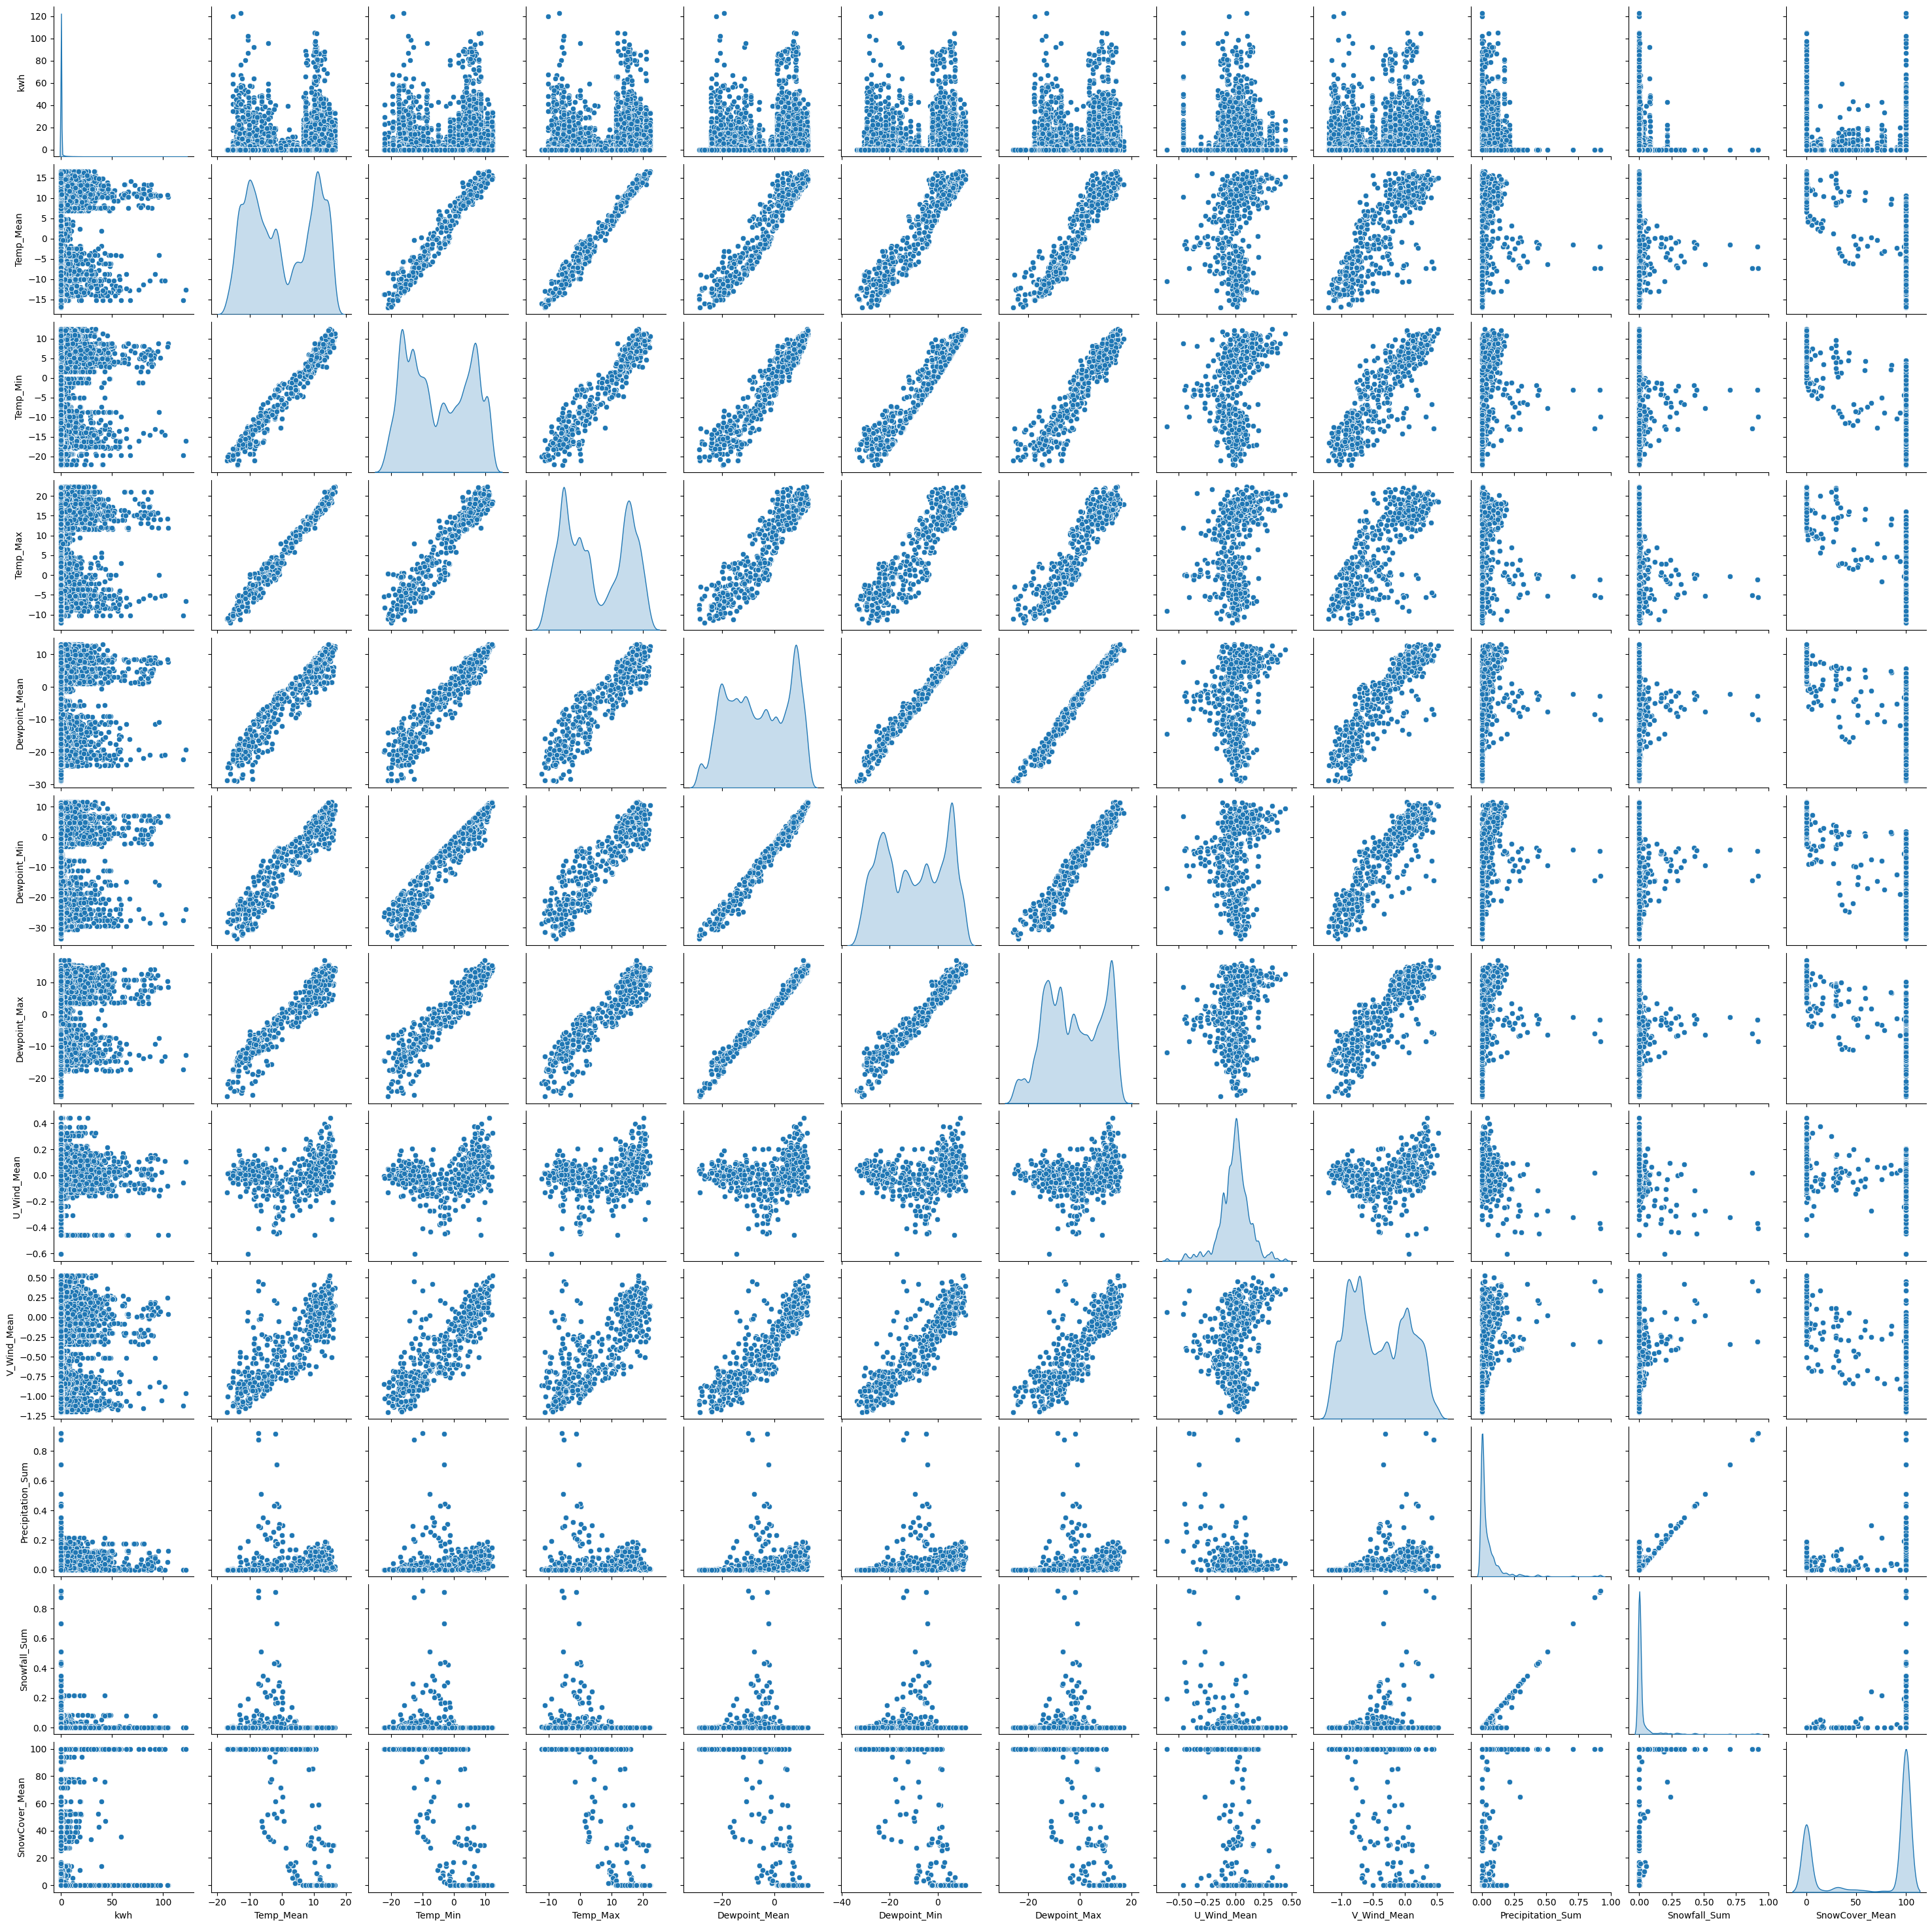

In [25]:
sns.pairplot(merged_daily.sample(100000, axis=0), diag_kind='kde')
#Image(filename='../images/all_var_corr.png')

In [26]:
#plt.figure(figsize=(12, 8))
#sns.heatmap(merged_daily.drop(columns='Source').corr().round(2), annot=True, cmap='seismic')
#plt.show()
Image(filename='../images/all_var_heatmap.png')

*Strong correlations between:*
- *temperature variables*
- *precipitation & snowfall*
- *temperature variables & v wind component*

*Weak correlations between:*
- *temperature variables & snow cover*

---
## Time series visualization

In [27]:
df_vis = merged_daily.groupby(['Date']).agg({
    "kwh": [("q50", lambda x: x.quantile(0.50)), ("q25", lambda x: x.quantile(0.25)), ("q75", lambda x: x.quantile(0.75))],
    "Temp_Mean": [("", lambda x: x.quantile(0.50))],
    "Temp_Min": [("", lambda x: x.quantile(0.50))],
    "Temp_Max": [("", lambda x: x.quantile(0.50))],
    "Dewpoint_Mean": [("", lambda x: x.quantile(0.50))],
    "Dewpoint_Min": [("", lambda x: x.quantile(0.50))],
    "Dewpoint_Max": [("", lambda x: x.quantile(0.50))],
    "U_Wind_Mean": [("", lambda x: x.quantile(0.50))],
    "V_Wind_Mean": [("", lambda x: x.quantile(0.50))],
    "Precipitation_Sum": [("", lambda x: x.quantile(0.50))],
    "Snowfall_Sum": [("", lambda x: x.quantile(0.50))],
    "SnowCover_Mean": [("", lambda x: x.quantile(0.50))]
})

# Flatten MultiIndex columns
df_vis.columns = [f"{col}_{stat}" for col, stat in df_vis.columns]
df_vis.columns = df_vis.columns.str.rstrip('_')

In [28]:
def plot_tseries_2_fill(x,
                        y1=None,
                        y2=None,
                        y1_fill_lower=None,
                        y1_fill_upper=None,
                        y1_scaling=None,
                        y2_fill_lower=None,
                        y2_fill_upper=None,
                        y2_scaling=None,
                        zero_hline=False,
                        y1_unit='',
                        y2_unit='',
                        title=''
                        ):
    """Plot time series of up to two variables with fill between ranges."""
    fig, ax1 = plt.subplots(figsize=(14, 5))
    if y1_fill_lower is not None and y1_fill_upper is not None:
        ax1.fill_between(x, y1_fill_lower, y1_fill_upper, facecolors='grey', alpha=0.5, label='inner quartiles')
    if y1 is not None:
        ax1.plot(x, y1, 'k-', label='median')
    if y1_scaling is not None:
        ax1.set_yscale(y1_scaling, linthresh=0.1)
        ax1.set_ylim(0)
    ax1.set_ylabel(y1_unit)
    ax1.tick_params(rotation=30)
    if y2 is not None or (y2_fill_lower is not None and y2_fill_upper is not None):
        ax2 = ax1.twinx()
        if y2_fill_lower is not None and y2_fill_upper is not None :
            ax2.fill_between(x, y2_fill_lower, y2_fill_upper, facecolors='skyblue', alpha=0.5, label='inner quartiles')
        if y2 is not None: 
            ax2.plot(x, y2, 'b-')
        if y2_scaling is not None:
            ax2.set_yscale(y1_scaling, linthresh=0.1)
            ax2.set_ylim(0)
        if zero_hline:
            ax2.hlines(0, x[0], x[-1], 'b', linestyles=':')
        ax2.set_ylabel(y2_unit)
        ax2.spines['right'].set_color('b')
        ax2.tick_params(axis='y', colors='b')
        ax2.yaxis.label.set_color('b')
    plt.xlim(x[0], x[-1])
    plt.title(title)
    plt.show()

### Regular climate variables:

In [29]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    title='Energy Consumption (kWh)'
                    )

In [30]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Temp_Mean'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    y2_fill_lower=df_vis['Temp_Min'].values,
                    y2_fill_upper=df_vis['Temp_Max'].values,
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(°C)',
                    title='Temperature'
                    )

In [31]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Dewpoint_Mean'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    y2_fill_lower=df_vis['Dewpoint_Min'].values,
                    y2_fill_upper=df_vis['Dewpoint_Max'].values,
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(°C)',
                    title='Dew Point Temperature'
                    )

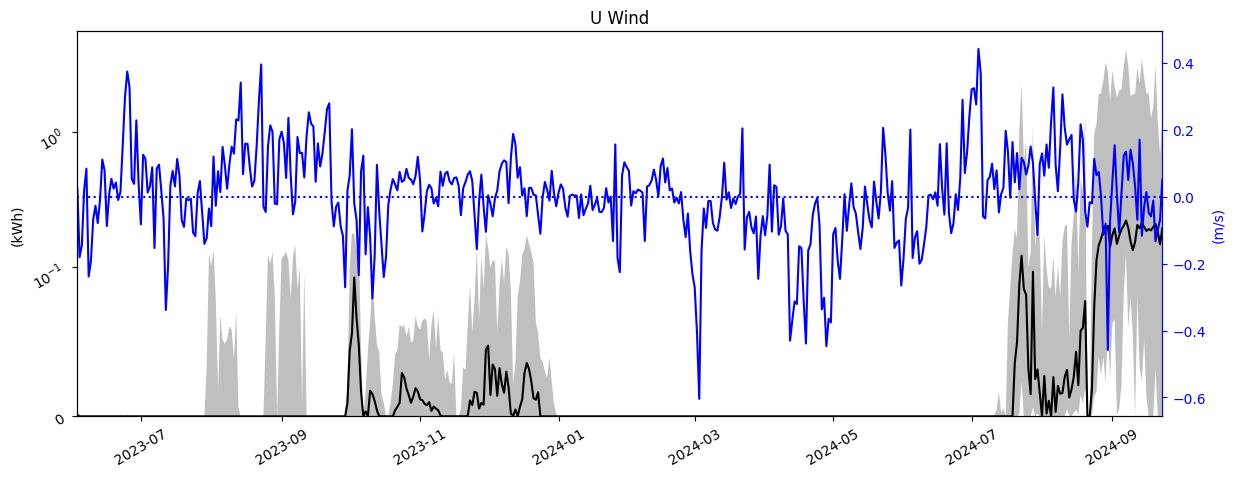

In [32]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['U_Wind_Mean'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(m/s)',
                    title='U Wind'
                    )

In [33]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['V_Wind_Mean'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(m/s)',
                    title='V Wind'
                    )

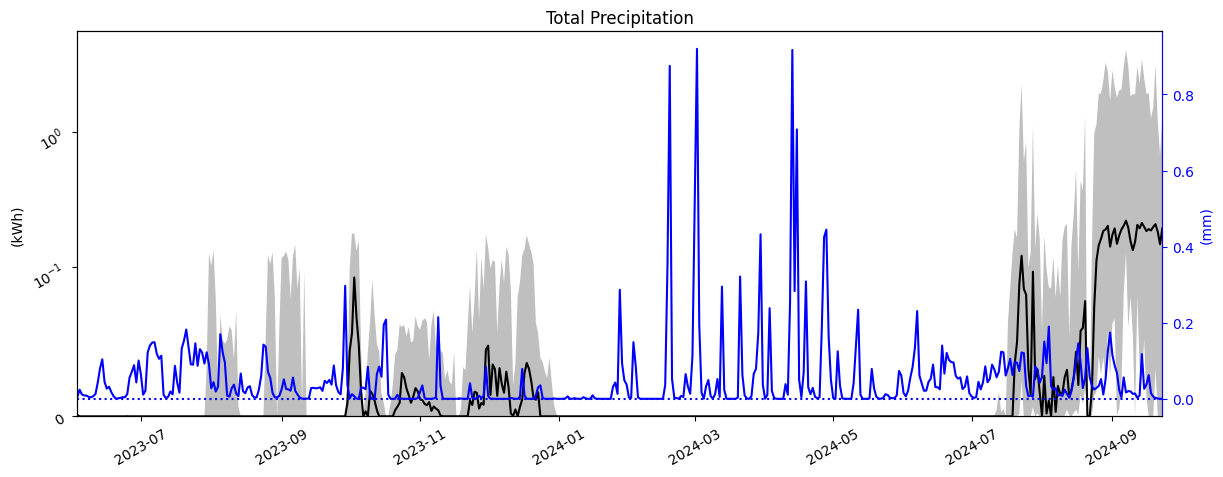

In [34]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Precipitation_Sum'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(mm)',
                    title='Total Precipitation'
                    )

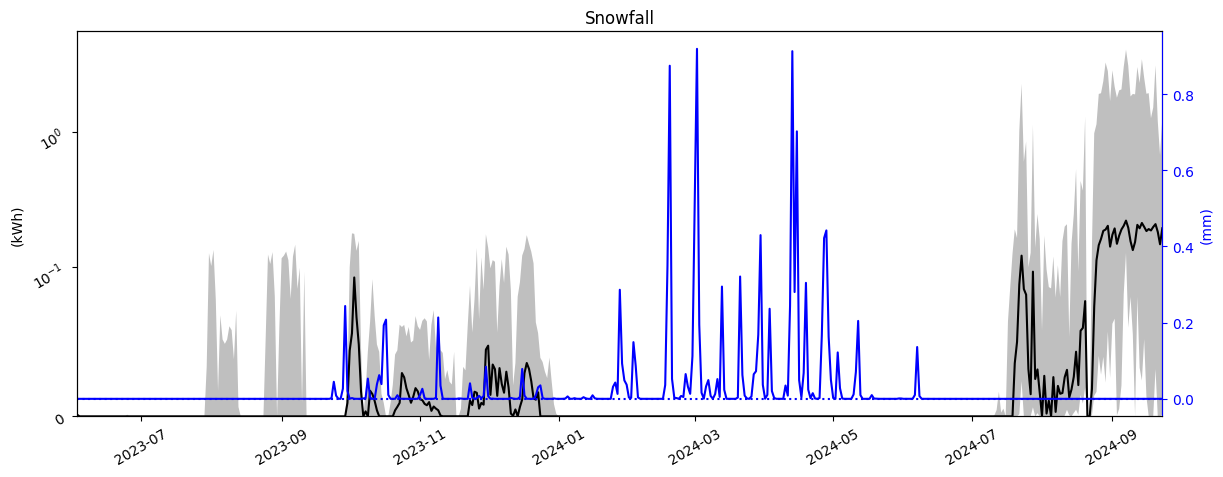

In [35]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Snowfall_Sum'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(mm)',
                    title='Snowfall'
                    )

In [36]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['SnowCover_Mean'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(%)',
                    title='Snow Cover'
                    )

### Feature engeneering:

In [37]:
df_vis["Temp_dew_diff"] = df_vis["Temp_Mean"] - df_vis["Dewpoint_Mean"]
df_vis["Wind_speed"] = np.sqrt(df_vis["U_Wind_Mean"]**2 + df_vis["V_Wind_Mean"]**2)
df_vis["Wind_direction"] = np.arctan2(-1*df_vis["U_Wind_Mean"], -1*df_vis["V_Wind_Mean"]) * 180/np.pi
df_vis["precip_snow_ratio"] = df_vis["Precipitation_Sum"] / (df_vis["Snowfall_Sum"] + 1e-6)

df_vis["Non_snow_prec"] = df_vis['Precipitation_Sum'] - df_vis['Snowfall_Sum']
df_vis["Snow_cover_x_temp"] = df_vis['SnowCover_Mean']/100 * df_vis['Temp_Mean']
df_vis["V_x_temp"] = df_vis['V_Wind_Mean'] * df_vis['Precipitation_Sum']
df_vis["U_x_temp"] = df_vis['U_Wind_Mean'] * df_vis['Precipitation_Sum']
df_vis["V_x_snow_cover"] = df_vis['V_Wind_Mean'] * df_vis['SnowCover_Mean']/100
df_vis["Non_snow_prec_x_temp_min"] = df_vis['Non_snow_prec'] * df_vis['Temp_Min']

In [38]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Temp_dew_diff'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(°C)',
                    title='Temperature minus Dew Point'
                    )

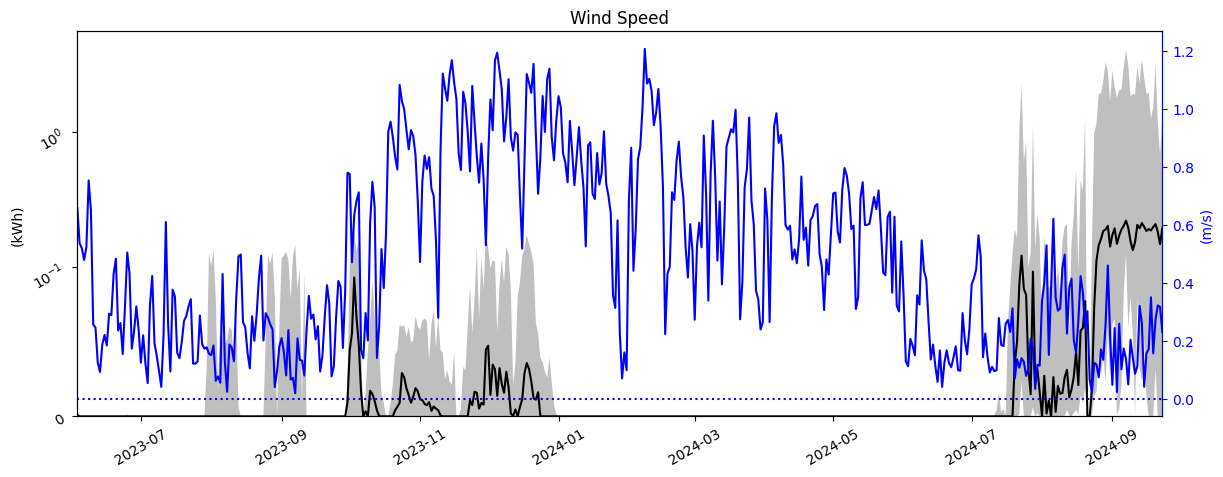

In [39]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Wind_speed'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(m/s)',
                    title='Wind Speed'
                    )

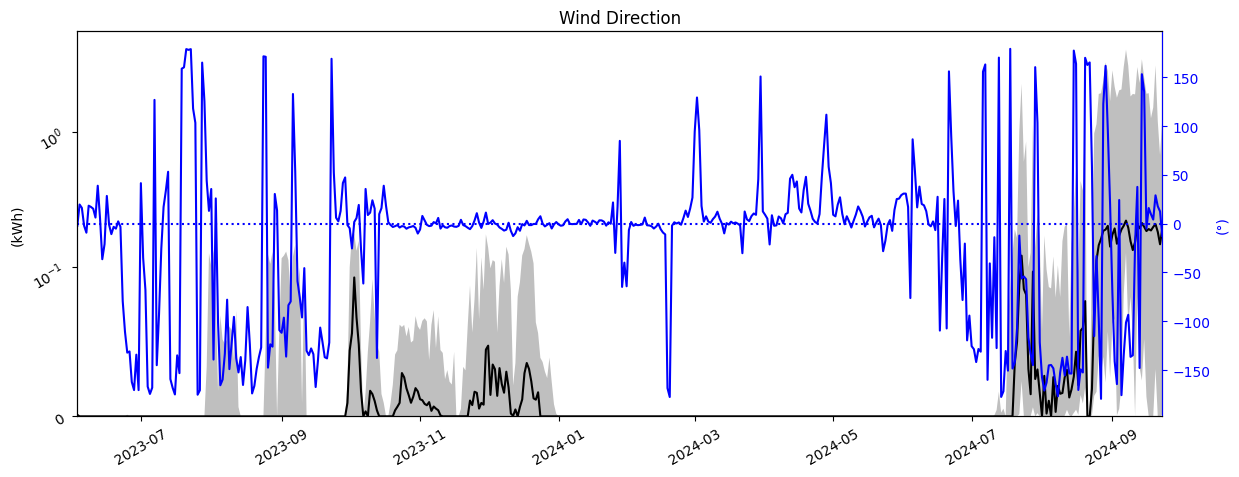

In [40]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Wind_direction'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(°)',
                    title='Wind Direction'
                    )

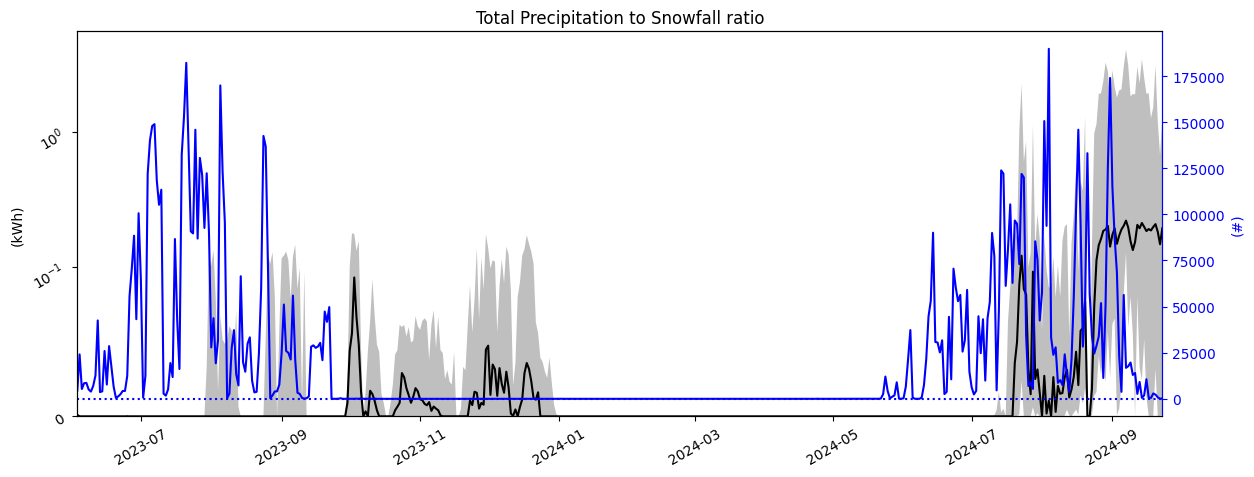

In [41]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['precip_snow_ratio'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(#)',
                    title='Total Precipitation to Snowfall ratio'
                    )

In [42]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Non_snow_prec'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(mm)',
                    title='Non Snow Precipitation'
                    )

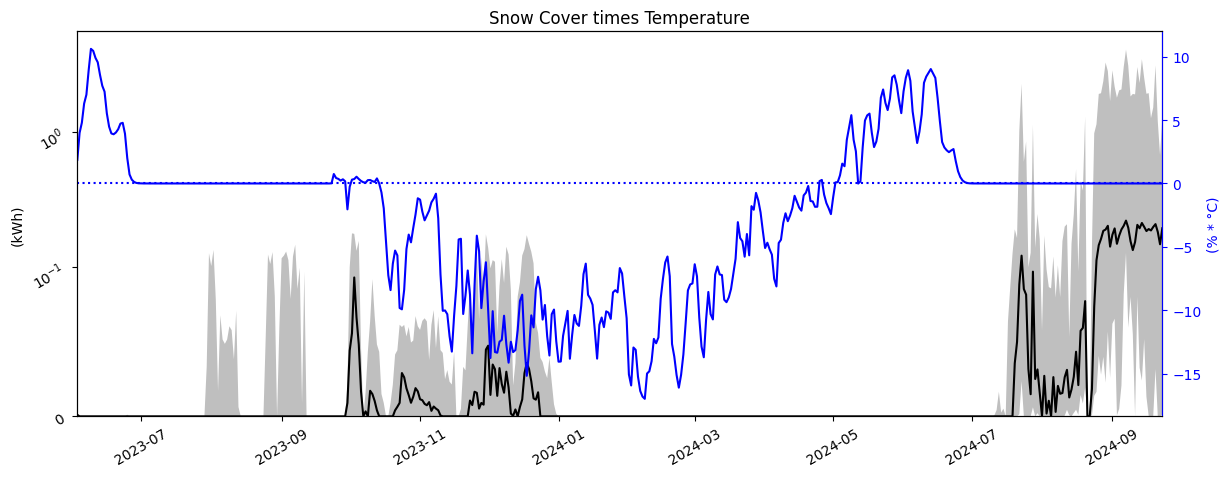

In [43]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Snow_cover_x_temp'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(% * °C)',
                    title='Snow Cover times Temperature'
                    )

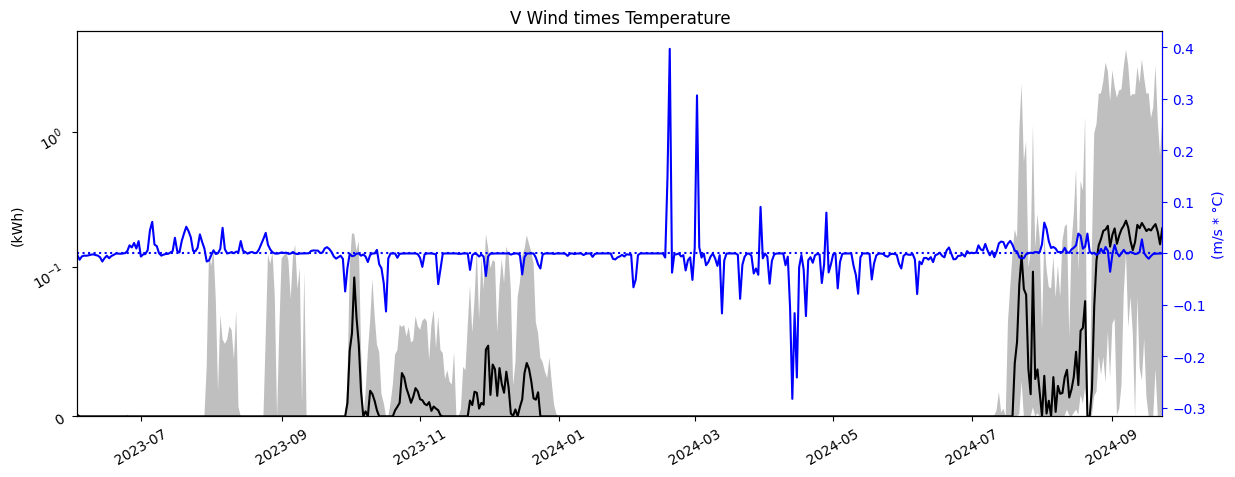

In [44]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['V_x_temp'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(m/s * °C)',
                    title='V Wind times Temperature'
                    )

In [45]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['U_x_temp'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(m/s * °C)',
                    title='U Wind times Temperature'
                    )

In [46]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['V_x_snow_cover'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(m/s * %)',
                    title='V Wind times Snow Cover'
                    )

In [47]:
plot_tseries_2_fill(df_vis.index,
                    df_vis['kwh_q50'].values,
                    df_vis['Non_snow_prec_x_temp_min'].values,
                    y1_fill_lower=df_vis['kwh_q25'].values,
                    y1_fill_upper=df_vis['kwh_q75'].values,
                    y1_scaling='symlog',
                    zero_hline=True,
                    y1_unit='(kWh)',
                    y2_unit='(mm * °C)',
                    title='Non Snow Precipitation times minimum Temperature'
                    )

*No tested combination of climate variables temporally correlates with the large gap of power consumption in winter. However, some features seam to correlate when beeing shifted in time by roughly 2 months:*
- *Temperatures (negative values)*
- *Snow Cover times Temperature (negative values)*
- *Non snow precipitation (positive values)*

---
---
# Time series decomposition

Let's try to decompose the energy consumption time series:

- seasonal patterns
- general trend
- residuals

Note: the seasonal_decompose function of the statsmodels package needs two complete cycles to be able to decompose the time series. Hence, we are not able to extract a yearly cycle here.

In [48]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

### Monthly seasonality:

[Text(0.5, 1.0, 'residual')]

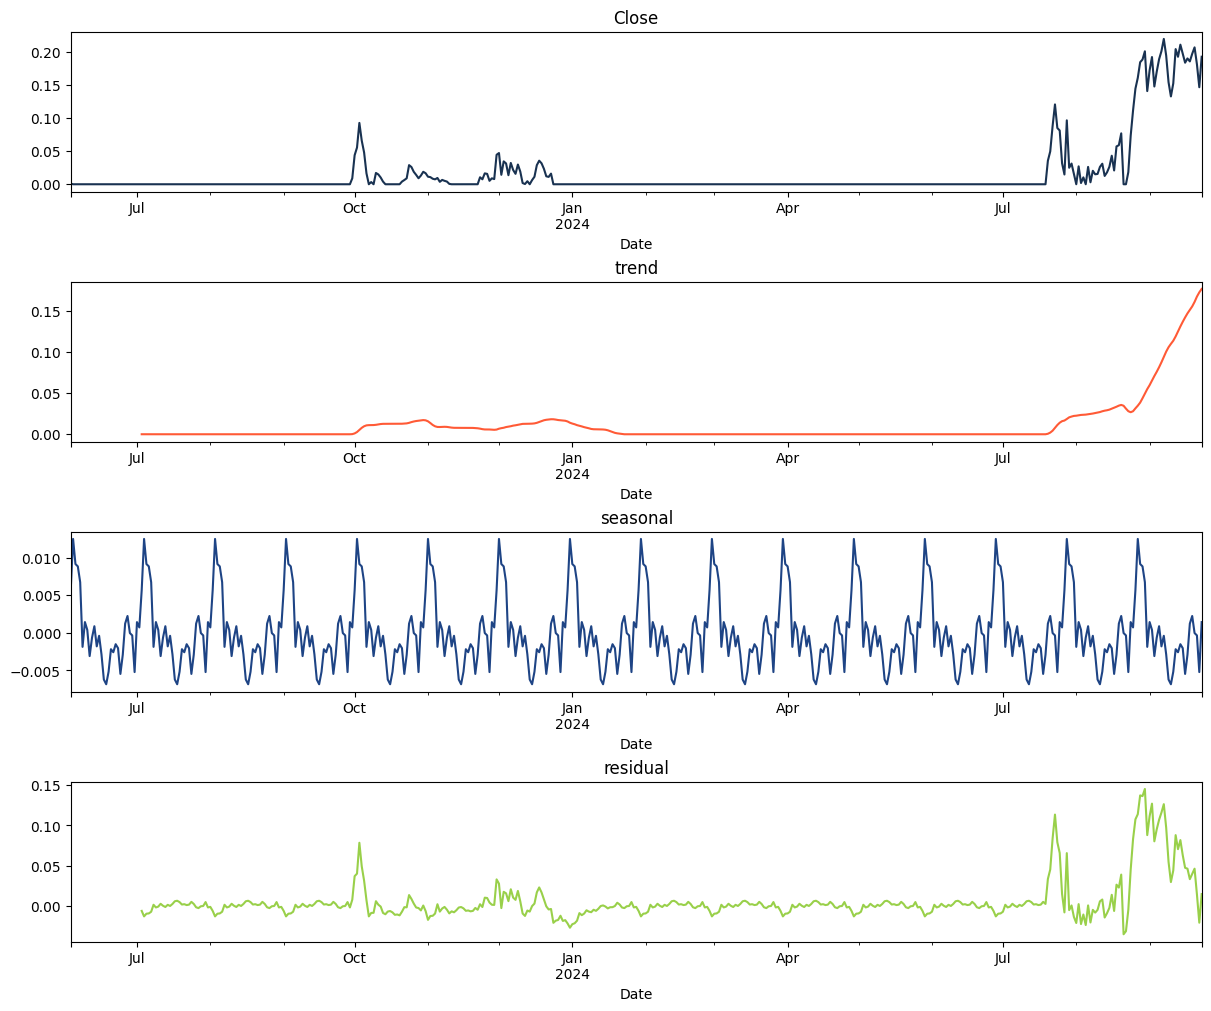

In [49]:
# Check for monthly seasonality
decomposition_year = seasonal_decompose(x=df_vis['kwh_q50'], 
                                   model='additive',
                                   two_sided=False,
                                   period=30)

fig, ax = plt.subplots(4, 1, figsize=(12, 10), constrained_layout=True)
decomposition_year.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Close')
decomposition_year.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition_year.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition_year.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')

### Weekly seasonality:

[Text(0.5, 1.0, 'residual')]

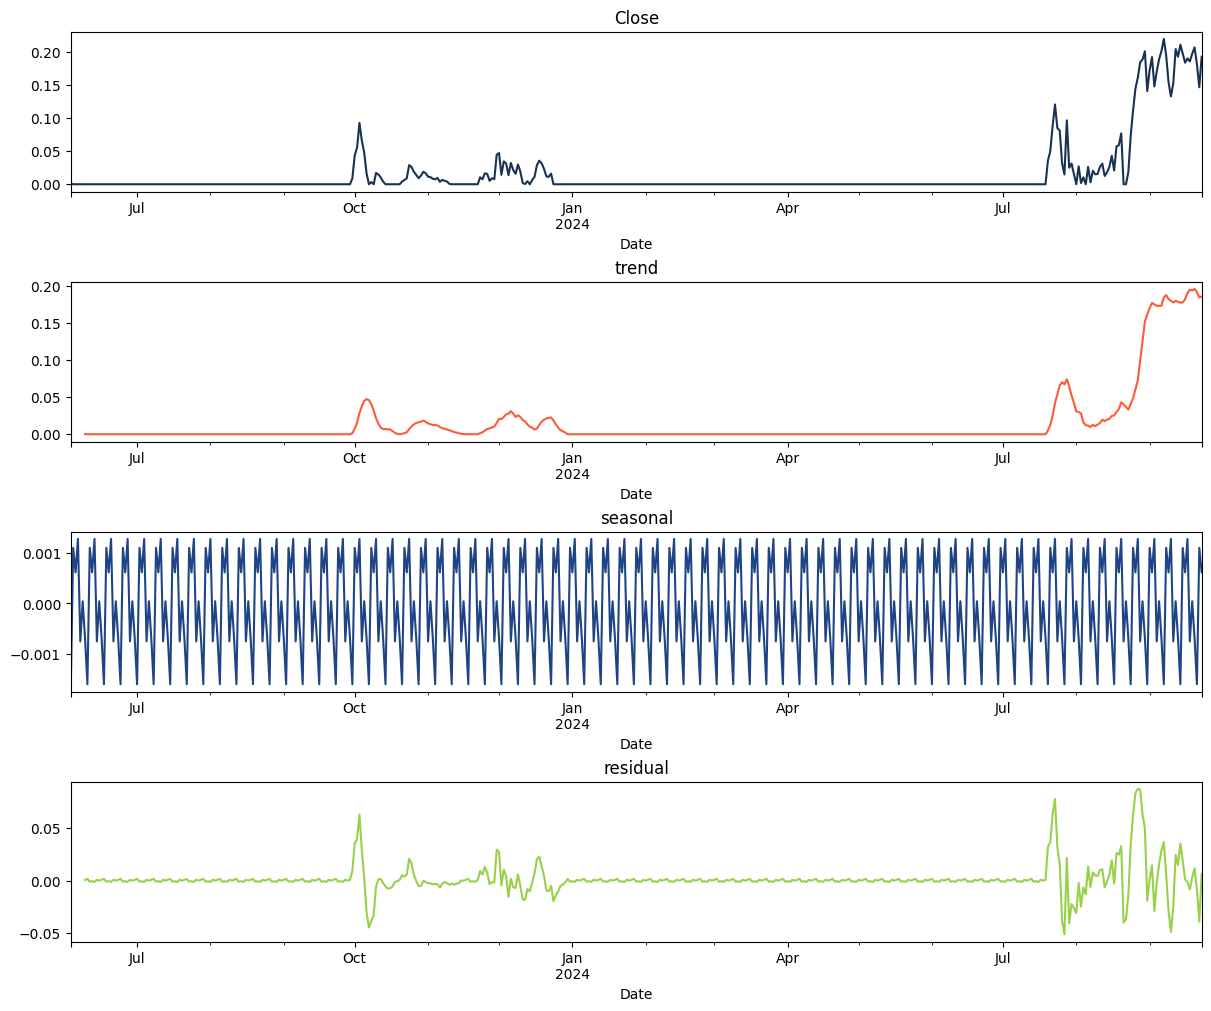

In [50]:
# Check for weekly seasonality
decomposition_year = seasonal_decompose(x=df_vis['kwh_q50'], 
                                   model='additive',
                                   two_sided=False,
                                   period=7)

fig, ax = plt.subplots(4, 1, figsize=(12, 10), constrained_layout=True)
decomposition_year.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Close')
decomposition_year.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition_year.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition_year.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')

<Axes: title={'center': 'Origional'}, xlabel='Date'>

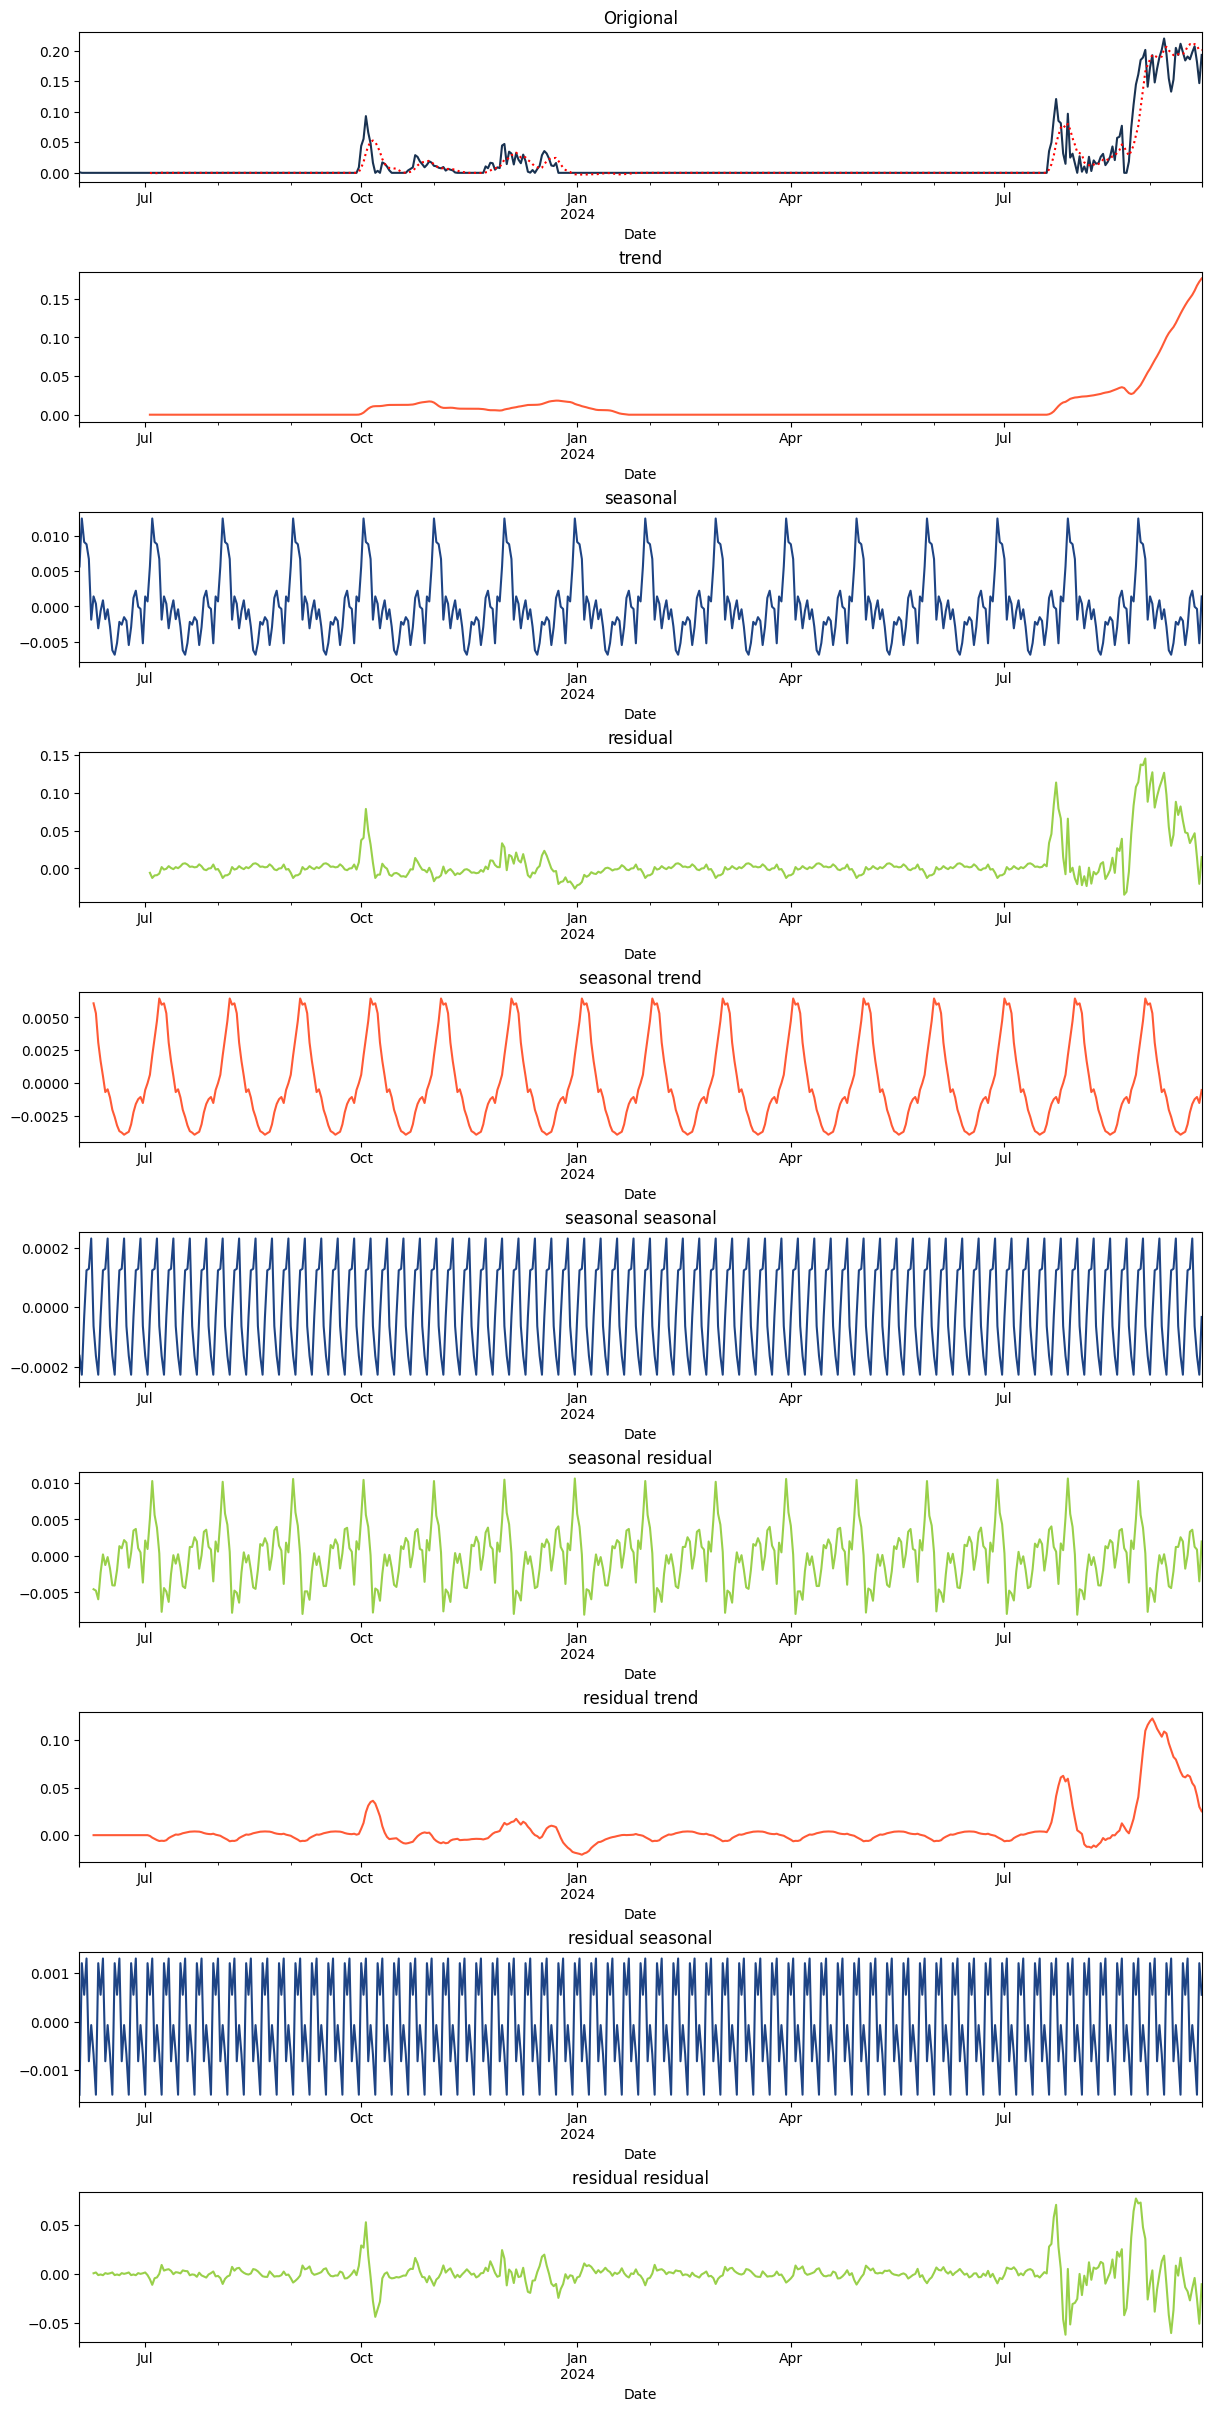

In [51]:
# Check for monthly seasonality
decomposition_year = seasonal_decompose(x=df_vis['kwh_q50'], 
                                   model='additive',
                                   two_sided=False,
                                   period=30)

fig, ax = plt.subplots(10, 1, figsize=(12, 24), constrained_layout=True)
decomposition_year.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='Origional')
decomposition_year.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition_year.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition_year.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')

# Check for weekly seasonality
decomposition_month = seasonal_decompose(x=decomposition_year.seasonal, 
                                   model='additive',
                                   two_sided=False,
                                   period=7)

decomposition_month.trend.plot(c=sns_c[1], ax=ax[4])
ax[4].set(title='seasonal trend')
decomposition_month.seasonal.plot(c=sns_c[2], ax=ax[5])
ax[5].set(title='seasonal seasonal')
decomposition_month.resid.plot(c=sns_c[3], ax=ax[6])
ax[6].set(title='seasonal residual')

decomposition_res = seasonal_decompose(x=decomposition_year.resid.fillna(0), 
                                   model='additive',
                                   two_sided=False,
                                   period=7)

decomposition_res.trend.plot(c=sns_c[1], ax=ax[7])
ax[7].set(title='residual trend')
decomposition_res.seasonal.plot(c=sns_c[2], ax=ax[8])
ax[8].set(title='residual seasonal')
decomposition_res.resid.plot(c=sns_c[3], ax=ax[9])
ax[9].set(title='residual residual')

decomposition_all = (decomposition_year.trend + decomposition_month.trend + decomposition_res.trend)

decomposition_all.plot(c='r', ax=ax[0], linestyle=':')

*The time series is too short to extract usable patterns. Also, the large gap of energy consumption during the winter drastically increases uncertainty.
Predicting one month into the future will rely mainly on lagged features and climate forecasts.*